In [260]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #

import xtrack as xt
import xobjects as xo
import xpart as xp
import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 

line = xt.Line.from_json('elena.json')
particle_ref = line.particle_ref
line.build_tracker()
twiss = line.twiss()

beta0=particle_ref.beta0
gamma0 = particle_ref.gamma0
circumference = twiss.circumference #m

clight=constants.speed_of_light
T_per_turn = circumference/(clight*beta0)

# # optics at e-cooler (approximate), in m
# beta_x=5
# beta_y=5
# D_x=1

ec_index=698

D_x=twiss.dx[ec_index]
D_y=twiss.dy[ec_index]

Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 12111.89it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [261]:
print('beta_x:',twiss.betx[ec_index])
print('beta_y:',twiss.bety[ec_index])
print('d_x:',twiss.dx[ec_index])
print('d_y:',twiss.dy[ec_index])

beta_x: 1.5167200298578212
beta_y: 2.64374313074297
d_x: 0.9887268976216608
d_y: 0.0


In [262]:
twiss.keys()
twiss.bets0

-469.32883416440933

In [263]:
num_particles=int(1e4)

beta_x_sem = 7.6 #m
beta_y_sem = 1.3 #m

#bunch_length=75*1e-9*clight #https://cds.cern.ch/record/2845870/files/document.pdf
bunch_intensity=5e7
sigma_dp = 1e-3*0
delta = np.random.normal(loc=0.0, scale=sigma_dp, size=num_particles)

sigma_z=-twiss.bets0*sigma_dp

print('sigma_z',sigma_z)

eps_x= 2.25*1e-6-(D_x*sigma_dp)**2/beta_x_sem
eps_x= 2.25*1e-6

gemitt_x = eps_x
gemitt_y = 2.25*1e-6
nemitt_x = gemitt_x*beta0*gamma0
nemitt_y = gemitt_y*beta0*gamma0

# particles = xp.generate_matched_gaussian_bunch(
#         num_particles=num_particles,
#         # total_intensity_particles=bunch_intensity,
#         nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=sigma_z,
#         particle_ref=particle_ref,
#         line=line,        
#         )

# particles.delta = np.random.normal(0, sigma_dp, num_particles)
# particles.zeta = np.random.uniform(-circumference/2, circumference/2, num_particles)
# particles0=particles.copy()


sigma_z 0.0


In [264]:
# electron cooler parameters
current = 0.34*1e-3 # A current
cooler_length = 1 # m cooler length
radius_e_beam = 14*1e-3 #m radius of the electron beam
temp_perp = 100e-3 # <E> [eV] = kb*T
temp_long =  1e-3 # <E> [eV]
magnetic_field = 0.010 # 100 Gauss in ELENA

electron_cooler = xt.ElectronCooler(
        length=cooler_length,
        radius_e_beam=radius_e_beam,
        current=current,
        temp_perp=temp_perp,
        temp_long=temp_long,
        magnetic_field=magnetic_field, 
        magnetic_field_ratio=1e-3,
        space_charge=1)

In [265]:
# simulation parameters: simulate 1 s of cooling, and take data once every 10 ms
max_time_s = 1.75
int_time_s = 0.01

# compute length of simulation, as well as sample interval, in turns
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=num_particles)

line.discard_tracker()

# line = xt.Line.from_json('elena_coasting.json')


line.insert_element('ecooler', element=electron_cooler, index=ec_index) #this way monitor comes after the cooler
line.insert_element('monitor', element=monitor, index=ec_index)

beta_x  = twiss.betx[ec_index]
beta_y  = twiss.bety[ec_index]
alpha_x = twiss.alfx[ec_index]
alpha_y = twiss.alfy[ec_index]
gamma_x = twiss.gamx[ec_index]
gamma_y = twiss.gamy[ec_index]

Dx  =  twiss.dx[ec_index]
Dpx =  twiss.dpx[ec_index]

Dy  =  twiss.dy[ec_index]
Dpy =  twiss.dpy[ec_index]

print(line.element_names[ec_index])

monitor


/tmp/ipykernel_2641/1891338104.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_turns = int(max_time_s/T_per_turn)
/tmp/ipykernel_2641/1891338104.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  save_interval = int(int_time_s/T_per_turn)


In [266]:
context = xo.ContextCpu(omp_num_threads=4)
# context = xo.ContextCupy()
# context = xo.ContextPyopencl()
line.build_tracker(_context=context)
# line.freeze_longitudinal()
line.optimize_for_tracking()

# Build a line without spacecharge (recycling the track kernel)
line_sc_off = line.filter_elements(exclude_types_starting_with='SpaceCh')
line_sc_off.build_tracker(track_kernel=line.tracker.track_kernel)

# (we choose to match the distribution without accounting for spacecharge)
particles = xp.generate_matched_gaussian_bunch(line=line_sc_off,
         num_particles=num_particles, total_intensity_particles=bunch_intensity,
         nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=sigma_z)

line_table = line.get_table()
element_mask = np.where(line_table['element_type']=='Cavity')[0]
for i in element_mask:
    cav_name = line_table['name'][i]
    line.elements[i].voltage = 0
    line.elements[i].frequency = 0
print('All cavities switched off.')

# just track all particles, and keep turn-by-turn data (memory expensive!)
line.track(particles, num_turns=num_turns,
              turn_by_turn_monitor=False,with_progress=True)



Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


Tracking: 100%|██████████| 251900/251900 [33:34<00:00, 125.07it/s]


In [267]:
 # extract relevant values
x = monitor.x[:,:,0]
px = monitor.px[:,:,0]
y = monitor.y[:,:,0]
py = monitor.py[:,:,0]
delta = monitor.delta[:,:,0]
zeta = monitor.zeta[:,:,0]
time = monitor.at_turn[:, 0, 0] * T_per_turn

# compute actions. for x, remove the dp/p contribution:
action_x = ((x-D_x*delta)**2/beta_x + beta_x*px**2)
action_y = (y**2/beta_y + beta_y*py**2)

action_x = (gamma_x*(x-Dx*delta)**2 
            + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta) 
            + beta_x*(px-Dpx*delta)**2)
action_y = (gamma_y*(y-Dy*delta)**2
             + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta) 
             + beta_y*(py-Dpy*delta)**2)

norm_emittance_x=np.mean(action_x,axis=1)/2*gamma0*beta0
norm_emittance_y=np.mean(action_y,axis=1)/2*gamma0*beta0

geo_emittance_x=np.mean(action_x,axis=1)/2
geo_emittance_y=np.mean(action_y,axis=1)/2


np.savez(f'results/IPAC_nonlinear.npz',
        
        # emittance_x_twiss=emittance_x_twiss,
        # emittance_y_twiss=emittance_y_twiss,
        geo_emittance_x=geo_emittance_x,
        geo_emittance_y=geo_emittance_y,
        norm_emittance_x=norm_emittance_x,
        norm_emittance_y=norm_emittance_y,
        x=x,  
        y=y,  
        px=px,  
        py=py,
        delta=delta,
        zeta=zeta,
        time=time)  

In [268]:
print('geo_emittance_x',geo_emittance_x[0])
print('geo_emittance_y',geo_emittance_y[0])

geo_emittance_x 2.2543146083591308e-06
geo_emittance_y 2.2477692980527533e-06


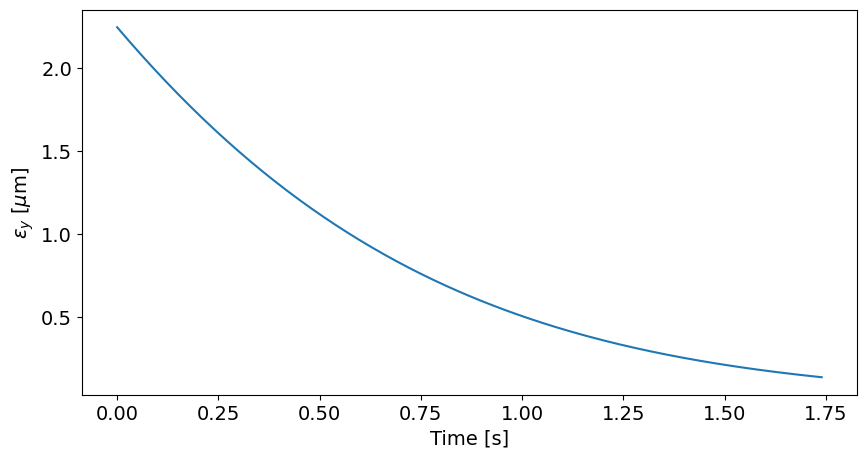

In [269]:
# plot some overall values
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 14})  # set the default fontsize to 14
plt.plot(time, geo_emittance_y * 1e6)
plt.xlabel('Time [s]')
plt.ylabel('$\\epsilon_y$ [$\\mu$m]')
plt.show()